# Hourly Energy Consumption

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('FE_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df

,FE_MW
Datetime,
2011-12-31 01:00:00,6222.0
2011-12-31 02:00:00,5973.0
2011-12-31 03:00:00,5778.0
2011-12-31 04:00:00,5707.0
2011-12-31 05:00:00,5691.0
...,...
2018-01-01 20:00:00,9378.0
2018-01-01 21:00:00,9255.0
2018-01-01 22:00:00,9044.0


<Axes: title={'center': 'Electricty Consumption Plot'}, xlabel='Datetime'>

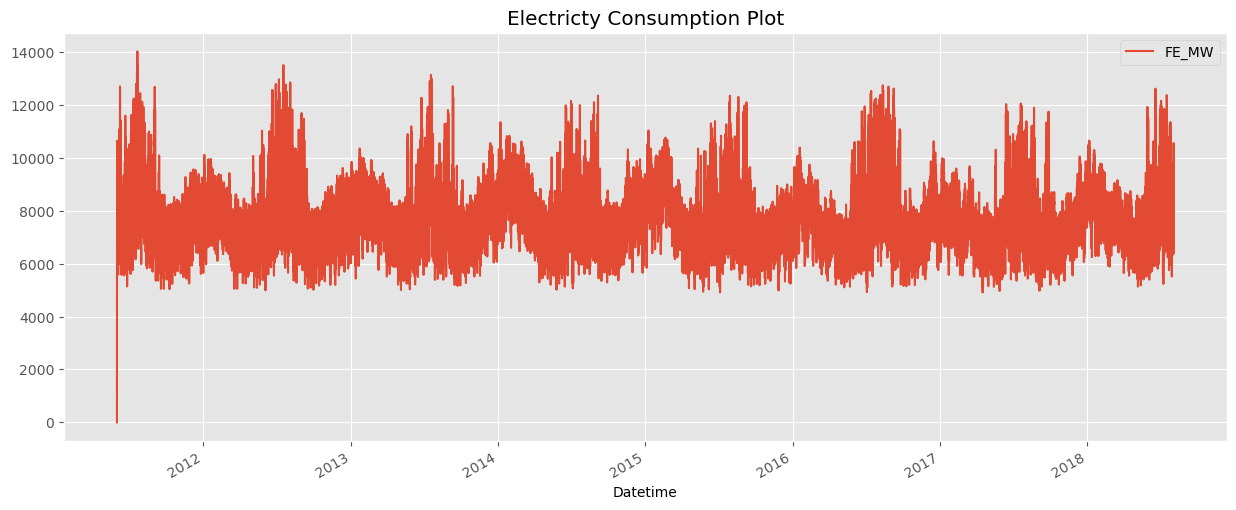

In [4]:
df.plot(title = 'Electricty Consumption Plot', figsize = (15,6))

In [5]:
df.index.min()

Timestamp('2011-06-01 01:00:00')

<Axes: title={'center': 'Detect Outlier'}, xlabel='Datetime'>

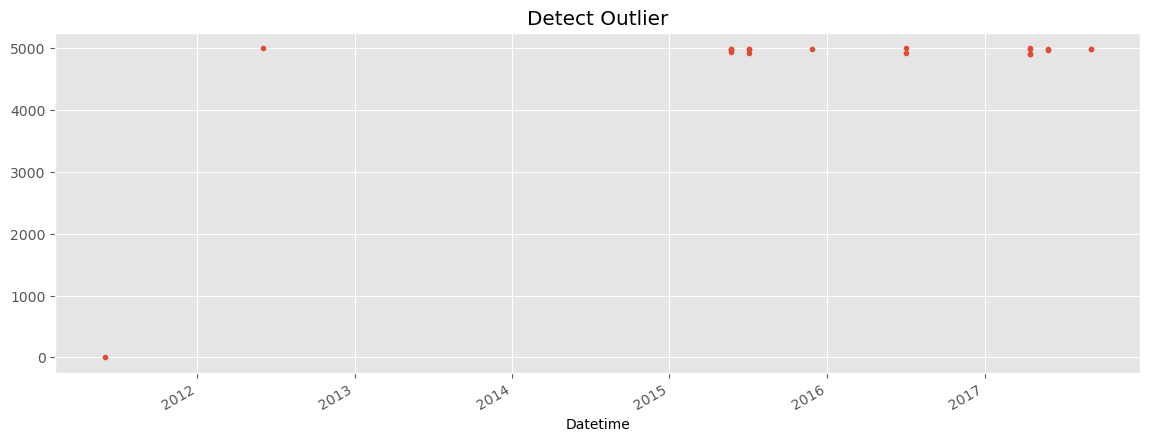

In [6]:
# Detect outlier
df.query('FE_MW < 5_000')['FE_MW'].plot(title = 'Detect Outlier', figsize = (14,5), style = '.')

In [10]:
dfnew = df.query('FE_MW > 2_000').copy()

In [11]:
train = dfnew.loc[dfnew.index < '2017-01-01']
test = dfnew.loc[dfnew.index >= '2017-01-01']

## Train Test Split

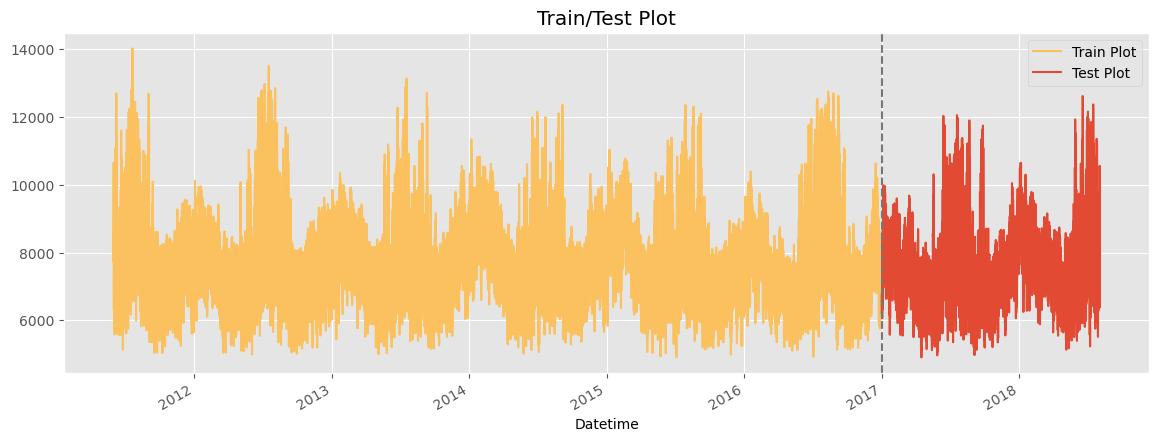

In [12]:
fig, ax = plt.subplots(figsize = (14,5))
train.plot(ax = ax, title = 'Train/Test Plot', color = color_pal[4])
test.plot(ax=ax)
plt.axvline(df.index[df.index == '2017-01-01'], ls = '--', color = color_pal[3])
ax.legend(['Train Plot', 'Test Plot'])
plt.show()

## Time Series Cross Validation

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size = 365*24, gap = 12)

In [14]:
dfnew = dfnew.sort_index()

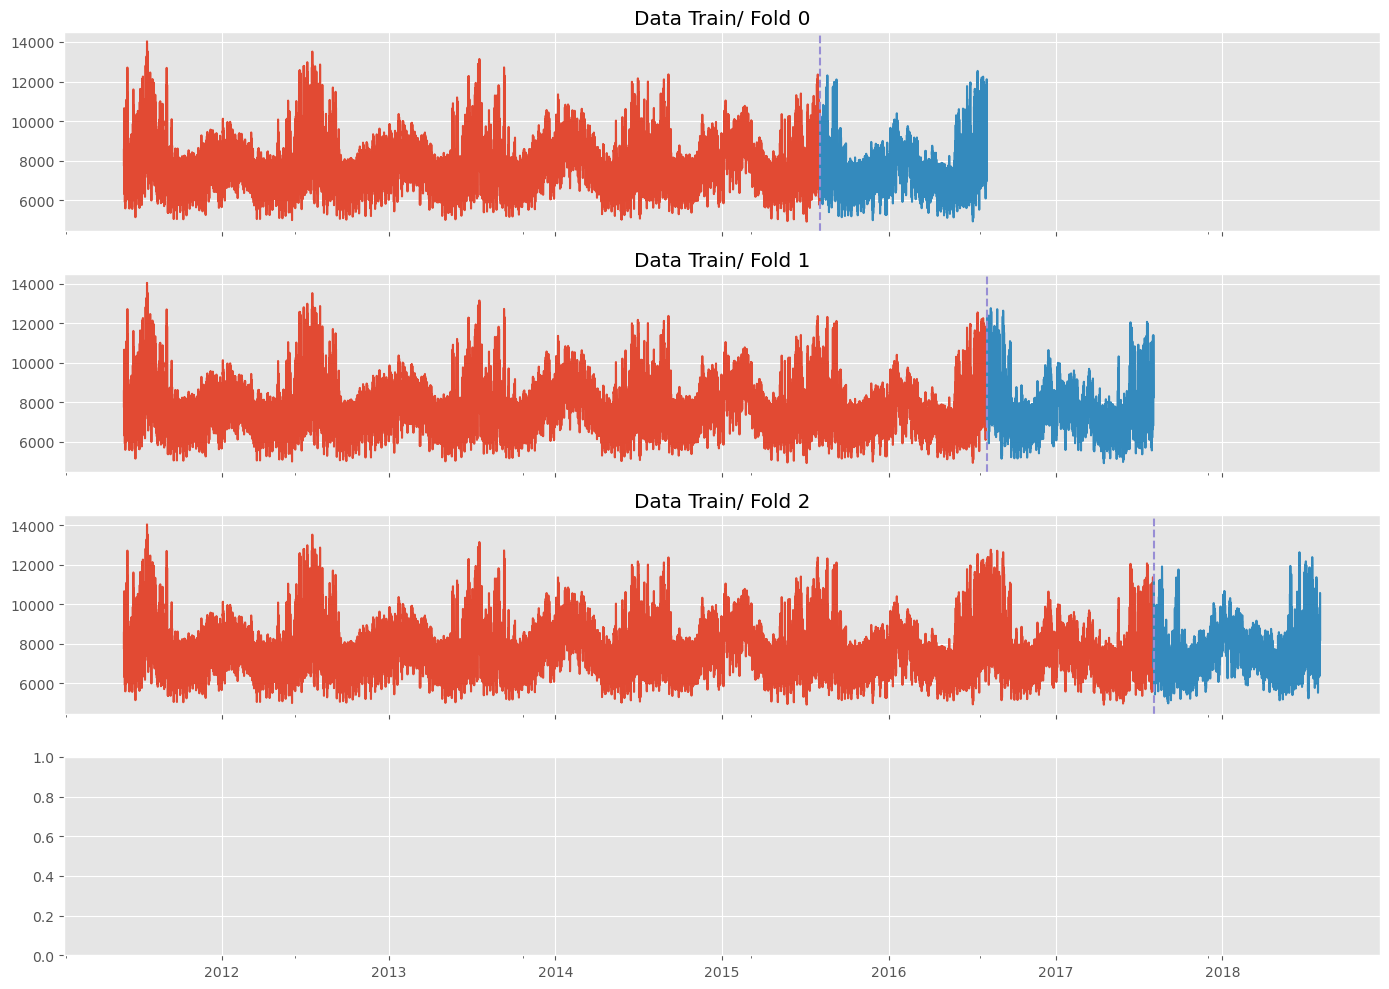

In [15]:
fig, axs = plt.subplots(4,1, figsize = (14,10), sharex = True)

fold = 0
for train_indx, val_indx in tss.split(dfnew):
    train = dfnew.iloc[train_indx]
    test =  dfnew.iloc[val_indx]
    train['FE_MW'].plot(ax = axs[fold], title = f'Data Train/ Fold {fold}')
    test['FE_MW'].plot(ax=axs[fold])
    axs[fold].axvline(test.index.min(), ls = '--', color = color_pal[2])
    fold += 1

fig.tight_layout()
plt.show()

## Forecasting Horizon

In [16]:
def create_features(data):
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['quarter'] = data.index.quarter
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    return data

df2 = create_features(dfnew)

## Lag Feature

In [17]:
def add_lag (data):
    target_map = df2['FE_MW'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
    data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    return data

In [18]:
df_lag = add_lag(df2)

## Train Using Cross Validation

In [19]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits= 4, test_size=365*24*1, gap = 12)
df_lag = df_lag.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_lag):
    train = df_lag.iloc[train_idx]
    test = df_lag.iloc[val_idx]
    
    train =create_features(train)
    test = create_features(test)
    
    features = ['hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear','dayofmonth', 'lag1', 'lag2', 'lag3']
    target = 'FE_MW'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    reg = XGBRegressor(n_estimators = 2000, max_depth = 3, objective = 'reg:linear', early_stopping_rounds = 50, learning_rate = 0.001, booster = 'gbtree')
    
    reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[13:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7960.39750	validation_1-rmse:7973.95349
[100]	validation_0-rmse:7213.97521	validation_1-rmse:7208.22092
[200]	validation_0-rmse:6539.71809	validation_1-rmse:6517.54521
[300]	validation_0-rmse:5930.78501	validation_1-rmse:5895.97393
[400]	validation_0-rmse:5380.99706	validation_1-rmse:5337.84008
[500]	validation_0-rmse:4884.81296	validation_1-rmse:4833.81782
[600]	validation_0-rmse:4437.13239	validation_1-rmse:4379.76363
[700]	validation_0-rmse:4033.44640	validation_1-rmse:3970.20006
[800]	validation_0-rmse:3669.47087	validation_1-rmse:3602.26665
[900]	validation_0-rmse:3341.80928	validation_1-rmse:3267.84811
[1000]	validation_0-rmse:3046.83784	validation_1-rmse:2966.63747
[1100]	validation_0-rmse:2781.72245	validation_1-rmse:2696.01463
[

In [20]:
print(f'RMSE avg score of all folds {np.mean(scores):0.4f}')
print(f'RSME score each fold {scores}')

RMSE avg score of all folds 1277.9345
RSME score each fold [1248.0625299950643, 1151.8752181491113, 1385.1765924217245, 1326.6237770822875]


In [21]:
folds = [1,2,3,4]
rmse_series = pd.Series(data = scores, index = folds)

Text(0.5, 1.0, 'RMSE score for each fold')

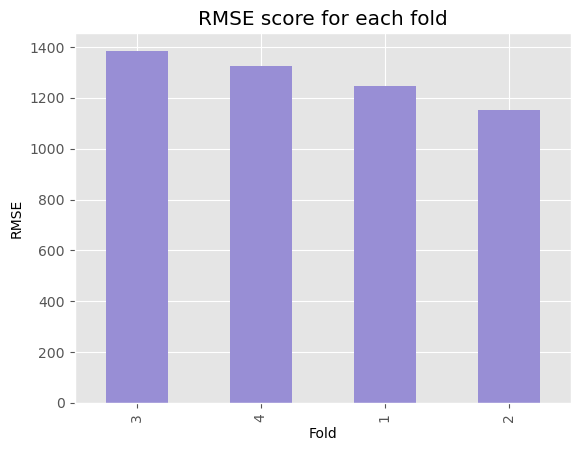

In [22]:
rmse_series.sort_values(ascending = False).plot(kind = 'bar', color = color_pal[2])
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE score for each fold')

## Future Prediction

In [23]:
df_lag = create_features(df_lag)

features = ['hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear','dayofmonth', 'lag1', 'lag2', 'lag3']
target = 'FE_MW'

X_all = df_lag[features]
y_all = df_lag[target]

reg = XGBRegressor(booster = 'gbtree', max_depth = 3, n_estimators = 2000, learning_rate = 0.001, early_stopping_rounds = 50, objective = 'reg:linear')

reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose = 100)

[21:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7896.83511
[100]	validation_0-rmse:7155.87201
[200]	validation_0-rmse:6486.47146
[300]	validation_0-rmse:5881.87334
[400]	validation_0-rmse:5335.93873
[500]	validation_0-rmse:4843.19070
[600]	validation_0-rmse:4398.65058
[700]	validation_0-rmse:3997.63955
[800]	validation_0-rmse:3636.43240
[900]	validation_0-rmse:3311.25139
[1000]	validation_0-rmse:3018.77950
[1100]	validation_0-rmse:2755.94688
[1200]	validation_0-rmse:2520.06748
[1300]	validation_0-rmse:2308.81879
[1400]	validation_0-rmse:2119.84139
[1500]	validation_0-rmse:1950.58287
[1600]	validation_0-rmse:1799.44911
[1700]	validation_0-rmse:1665.22768
[1800]	validation_0-rmse:1546.09977
[1900]	validation_0-rmse:1440.98700
[1999]	validation_0-rmse:1349.36330


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [24]:
df_lag.index.max()

Timestamp('2018-08-03 00:00:00')

In [25]:
# Make Future Dataset

future = pd.date_range('2018-08-03', '2019-09-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df_lag['isFuture'] = False
df_and_future = pd.concat([df_lag, future_df])
df_and_future = create_features(df_and_future)
df_and_future =  add_lag(df_and_future)

In [26]:
future_w_features = df_and_future.query('isFuture').copy()

In [27]:
df_and_future

,FE_MW,hour,dayofweek,month,year,quarter,dayofyear,dayofmonth,lag1,lag2,lag3,isFuture
2011-06-01 02:00:00,8548.0,2,2,6,2011,2,152,1,NaN,NaN,NaN,False
2011-06-01 03:00:00,8121.0,3,2,6,2011,2,152,1,NaN,NaN,NaN,False
2011-06-01 04:00:00,7801.0,4,2,6,2011,2,152,1,NaN,NaN,NaN,False
2011-06-01 05:00:00,7729.0,5,2,6,2011,2,152,1,NaN,NaN,NaN,False
2011-06-01 06:00:00,7968.0,6,2,6,2011,2,152,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 20:00:00,NaN,20,5,8,2019,3,243,31,NaN,6249.0,7253.0,True
2019-08-31 21:00:00,NaN,21,5,8,2019,3,243,31,NaN,6492.0,7281.0,True
2019-08-31 22:00:00,NaN,22,5,8,2019,3,243,31,NaN,6317.0,7039.0,True
2019-08-31 23:00:00,NaN,23,5,8,2019,3,243,31,NaN,6088.0,6632.0,True


## Future Prediction

In [28]:
future_w_features['pred'] = reg.predict(future_w_features[features])

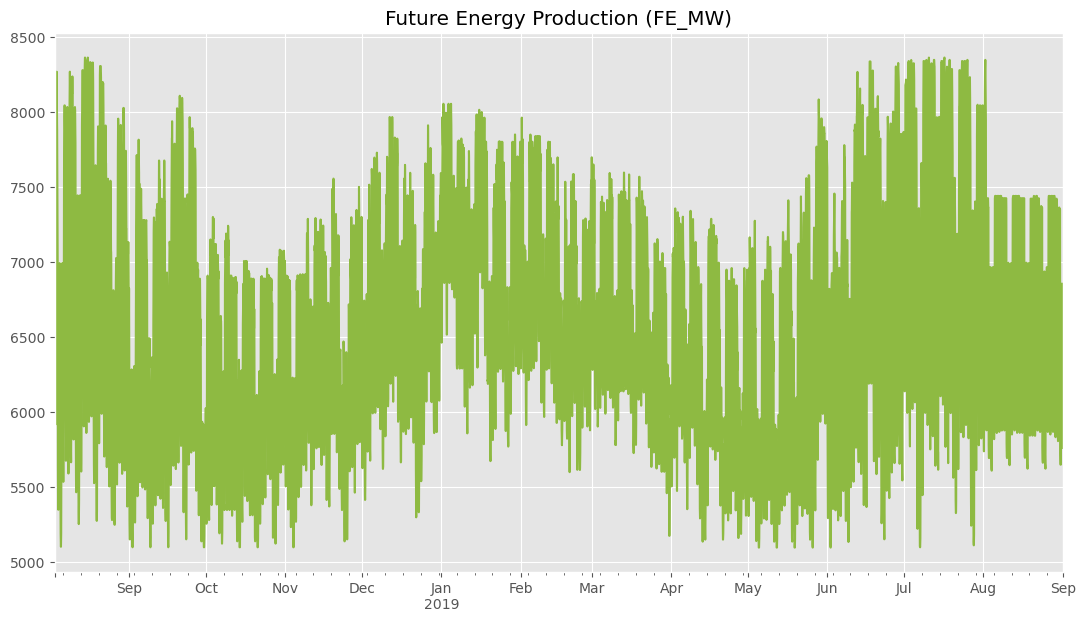

In [29]:
future_w_features['pred'].plot(figsize = (13,7), title = 'Future Energy Production (FE_MW)', color = color_pal[5])
plt.show()

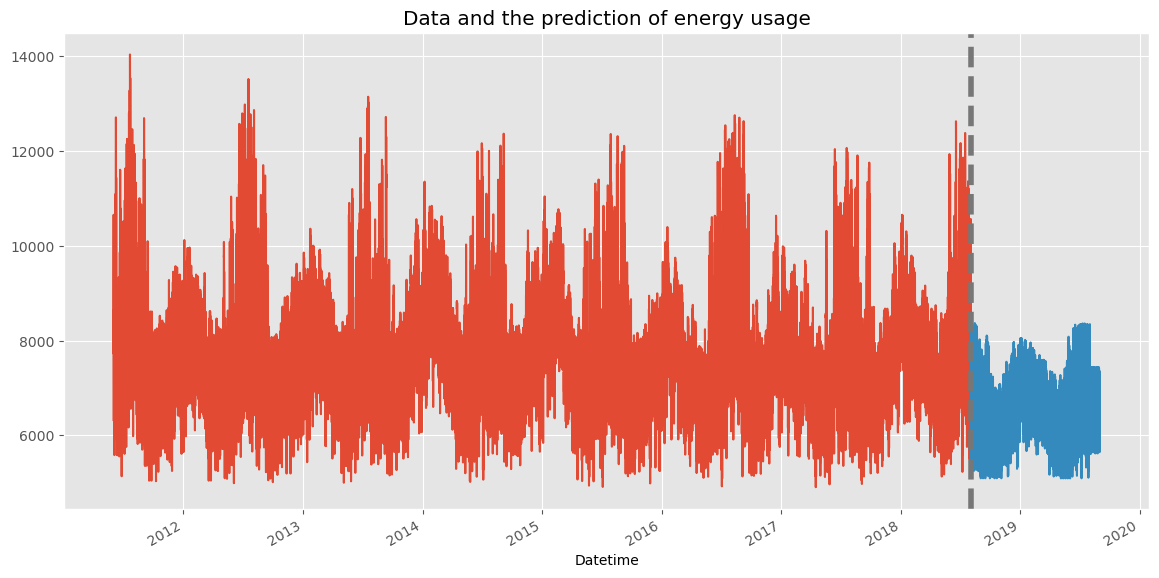

In [30]:
fig,ax = plt.subplots(figsize = (14,7))

df_lag[target].plot(ax=ax, title = 'Data and the prediction of energy usage')
future_w_features['pred'].plot(ax=ax)
plt.axvline(df_lag.index[df_lag.index == df_lag.index.max()], ls = '--', color = color_pal[3], linewidth= 4)
plt.show()